In [8]:
using Pkg
Pkg.develop("QuantumDots")
Pkg.activate(pwd())
Pkg.instantiate()
using QuantumDots, QuantumDots.BlockDiagonals, LinearAlgebra
using Plots
#using Symbolics
using Latexify
using LinearSolve # Solving for stationary state
#using OrdinaryDiffEq # For time evolution
import SymPy # For analytic solutions
import Symbolics


   Resolving package versions...


  No Changes to `C:\Users\svens\.julia\dev\QuantumDots\examples\Project.toml`
    Updating `C:\Users\svens\.julia\dev\QuantumDots\examples\Manifest.toml`


  [621f4979] + AbstractFFTs v1.5.0
  [94b1ba4f] + AxisKeys v0.2.13
  [587fd27a] + CovarianceEstimation v0.2.9
  [a8cc5b0e] + Crayons v4.1.1
  [41ab1584] + InvertedIndices v1.3.0
⌅ [1fad7336] + LazyStack v0.0.8
  [356022a1] + NamedDims v1.2.1
        Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated -m`
  Activating project at `c:\Users\svens\.julia\dev\QuantumDots\examples`

Precompiling

project...

  ✓ 

CovarianceEstimation

  ✓ NamedDims


  ✓ LazyStack


  ✓ AxisKeys


  ✓ QuantumDots


  ✓ QuantumDots → QuantumDotsForwardDiffExt


  ✓ QuantumDots → QuantumDotsSymbolicsExt
  7 dependencies successfully precompiled in 27 seconds. 335 already precompiled.


**Table of contents**<a id='toc0_'></a>    
- [Intro to QuantumDots.jl](#toc1_)    
    - [Defining a basis](#toc1_1_1_)    
    - [Kitaev chain hamiltonian](#toc1_1_2_)    
      - [Diagonalizing the Hamiltonian](#toc1_1_2_1_)    
      - [Majorana quality measures](#toc1_1_2_2_)    
      - [Using SymPy for analytical solutions](#toc1_1_2_3_)    
    - [Optimizing for the sweet spot](#toc1_1_3_)    
    - [Transport](#toc1_1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Intro to QuantumDots.jl](#toc0_)

### <a id='toc1_1_1_'></a>[Defining a basis](#toc0_)
To specify a basis, define the indices and optionally a conserved quantum number


In [9]:
N=2
d = FermionBasis(1:N, (:↑, :↓); qn = QuantumDots.fermionnumber)

FermionBasis{4,Tuple{Int64, Symbol},SparseArrays.SparseMatrixCSC{Int64, Int64},QuantumDots.AbelianFockSymmetry{Vector{Int64}, Dictionaries.Dictionary{Int64, Int64}, Int64, typeof(QuantumDots.fermionnumber)}}:
keys = {(1, :↑), (2, :↑), (1, :↓), (2, :↓)}

The basis allows easy access to the fermionic operators in the many body basis, as well as dictionaries that define how the basis is ordered

In [10]:
d[1,:↑] #is a SparseArray representation of the annihilation operator

16×16 SparseArrays.SparseMatrixCSC{Int64, Int64} with 8 stored entries:
⎡⠈⠀⠠⡀⠀⠀⠀⠀⎤
⎢⠀⠀⠀⠀⠁⢀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠢⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠠⎦

In [11]:
Matrix(d[N,:↓]') # Creation operator. ' is hermitian conjugate. Use Matrix to convert to dense matrix.

16×16 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0

In [12]:
d[1,:↑]'d[1,:↑] # Number operator 

16×16 SparseArrays.SparseMatrixCSC{Int64, Int64} with 8 stored entries:
⎡⠐⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠐⠄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠁⢀⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠑⢀⎦

In [13]:
blockdiagonal(sum(f -> f'f, d), d) |> blocks .|> display; # Blocks of number operator

1×1 SparseArrays.SparseMatrixCSC{Int64, Int64} with 0 stored entries:
 ⋅

4×4 SparseArrays.SparseMatrixCSC{Int64, Int64} with 4 stored entries:
 1  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅
 ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  1

6×6 SparseArrays.SparseMatrixCSC{Int64, Int64} with 6 stored entries:
 2  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  2  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  2  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  2  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  2  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  2

4×4 SparseArrays.SparseMatrixCSC{Int64, Int64} with 4 stored entries:
 3  ⋅  ⋅  ⋅
 ⋅  3  ⋅  ⋅
 ⋅  ⋅  3  ⋅
 ⋅  ⋅  ⋅  3

1×1 SparseArrays.SparseMatrixCSC{Int64, Int64} with 1 stored entry:
 4

5-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing

In [14]:
d.symmetry.qntofockstates

5-element Dictionaries.Dictionary{Int64, Vector{Int64}}
 0 │ [0]
 1 │ [1, 2, 4, 8]
 2 │ [3, 5, 6, 9, 10, 12]
 3 │ [7, 11, 13, 14]
 4 │ [15]

In [15]:
d.symmetry.indtofockdict

16-element Vector{Int64}:
  0
  1
  2
  4
  8
  3
  5
  6
  9
 10
 12
  7
 11
 13
 14
 15

In [17]:
pretty_print(rand(4^N), d)

labels = |(1, :↑),(2, :↑),(1, :↓),(2, :↓)>
QN = 0
 |0000> : 0.567
QN = 1
 |1000> : 0.925
 |0100> : 0.527
 |0010> : 0.311
 |0001> : 0.226
QN = 2
 |1100> : 0.608
 |1010> : 0.603
 |0110> : 0.138
 |1001> : 0.797
 |0101> : 0.847
 |0011> : 0.445
QN = 3
 |1110> : 0.077
 |1101> : 0.857
 |1011> : 0.058
 |0111> : 0.257
QN = 4
 |1111> : 0.0


Any quantum number which is diagonal in the fock basis is supported

In [20]:
uniqn(focknbr) =
    if iseven(focknbr)
        return :🦄
    else
        if focknbr > 2
            return :👹
        else
            return :🌯
        end
    end
d2 = FermionBasis(1:2; qn=uniqn)

FermionBasis{2,Int64,SparseArrays.SparseMatrixCSC{Int64, Int64},QuantumDots.AbelianFockSymmetry{Vector{Int64}, Dictionaries.Dictionary{Int64, Int64}, Symbol, typeof(uniqn)}}:
keys = {1, 2}

In [30]:
pretty_print(rand(2^length(d2)), d2)

labels = |1,2>
QN = 🌯


 |10> : 0.839
QN = 👹
 |11> : 0.182
QN = 🦄
 |00> : 0.872
 |01> : 0.79


In [31]:
pretty_print(rand(2^length(d2),2^length(d2)), d2)

2-dimensional KeyedArray(NamedDimsArray(...)) with keys:
↓   row ∈ 4-element Vector{QuantumDots.ColoredString{Int64}}
→   col ∈ 4-element Vector{QuantumDots.ColoredString{Int64}}
And data, 4×4 Matrix{Float64}:
            ("|10>")   ("|11>")    ("|00>")   ("|01>")
  ("|10>")   0.379507   0.512786    0.55556    0.527395
  ("|11>")   0.409383   0.0777236   0.735078   0.273807
  ("|00>")   0.403349   0.101544    0.281156   0.472439
  ("|01>")   0.732819   0.0747117   0.537616   0.85937

labels = |12>
QNs = [🌯, 👹, 🦄,]


There is also a free fermion version. Multiplying two BdG fermions gives a BdG matrix.

In [12]:
b = QuantumDots.FermionBdGBasis(1:N, (:↑, :↓))
Symbolics.@variables μ[1:N, (:↑, :↓)] #Create symbolic array
sum(map((n, f) -> μ[n] * (f'f), 1:length(b), b)) # BdG hamiltonian 

8×8 SparseArrays.SparseMatrixCSC{Symbolics.Num, Int64} with 8 stored entries:
 μ[1, 1]        ⋅        ⋅        ⋅         ⋅         ⋅         ⋅         ⋅
       ⋅  μ[2, 1]        ⋅        ⋅         ⋅         ⋅         ⋅         ⋅
       ⋅        ⋅  μ[1, 2]        ⋅         ⋅         ⋅         ⋅         ⋅
       ⋅        ⋅        ⋅  μ[2, 2]         ⋅         ⋅         ⋅         ⋅
       ⋅        ⋅        ⋅        ⋅  -μ[1, 1]         ⋅         ⋅         ⋅
       ⋅        ⋅        ⋅        ⋅         ⋅  -μ[2, 1]         ⋅         ⋅
       ⋅        ⋅        ⋅        ⋅         ⋅         ⋅  -μ[1, 2]         ⋅
       ⋅        ⋅        ⋅        ⋅         ⋅         ⋅         ⋅  -μ[2, 2]

And a Qubit basis:

In [13]:
Q = QuantumDots.QubitBasis(1:N)
Q[1] # Lowering operator of first qubit
Q[1,:X] #X operator acting on the first qubit (X⊗I)

4×4 SparseArrays.SparseMatrixCSC{Int64, Int64} with 4 stored entries:
 ⋅  1  ⋅  ⋅
 1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1
 ⋅  ⋅  1  ⋅

### <a id='toc1_1_2_'></a>[Kitaev chain hamiltonian](#toc0_)
We'll implement the interacting Kitaev chain hamiltonian
$$
\begin{equation}
H = \sum_{n = 1}^N \mu c_n^\dagger c_n + \sum_{n=1}^{N-1} (t c_{n+1}^\dagger c_n + \Delta c_{n+1}c_n + \mathrm{h.c}) + V c_{n+1}^\dagger c_{n+1} c_n^\dagger c_n,
\end{equation}
$$
and calculate the energy gap and majorana polarization. We'll use these to tune for a sweet spot where the system has two separated majoranas.

In [14]:
N = 2
c = FermionBasis(1:N, qn=QuantumDots.parity)
cBdG = QuantumDots.FermionBdGBasis(1:N)
ham(μ, t, Δ, V, c=c) = Hermitian(sum(μ * c[n]'c[n] for n in 1:N) + sum(t * c[n+1]'c[n] + Δ * c[n+1]c[n] + hc for n in 1:N-1) + ham_int(V, c))
ham_int(V, c) = V * sum(c[n]'c[n]c[n+1]'c[n+1] for n in 1:N-1)
ham_int(V, c::QuantumDots.FermionBdGBasis) = zero(first(c)first(c))

ham_int (generic function with 2 methods)

In [15]:
SymPy.@syms μ::real t::real Δ::real V::real # Define some symbolic variables
#Many body hamiltonian
ham(μ, t, Δ, V) # |> latexify |> println # Uncomment to print latex code 

4×4 Hermitian{SymPy.Sym, SparseArrays.SparseMatrixCSC{SymPy.Sym, Int64}}:
 μ  t   0        0
 t  μ   0        0
 0  0   0       -Δ
 0  0  -Δ  V + 2*μ

In [16]:
ham(μ, t, Δ, V, cBdG) #BdG hamiltonian

4×4 Hermitian{SymPy.Sym, SparseArrays.SparseMatrixCSC{SymPy.Sym, Int64}}:
 μ   t   0   Δ
 t   μ  -Δ   0
 0  -Δ  -μ  -t
 Δ   0  -t  -μ

#### <a id='toc1_1_2_1_'></a>[Diagonalizing the Hamiltonian](#toc0_)

In [17]:
function parity_eigen(H, c=c)
    eigs = diagonalize(blockdiagonal(H, c))
    energies = map(eig -> eig.values, blocks(eigs; full=true))
    states = map(eig -> eig.vectors, blocks(eigs; full=true))
    return energies, states, eigs
end

parity_eigen (generic function with 2 methods)

#### <a id='toc1_1_2_2_'></a>[Majorana quality measures](#toc0_)
The Majorana Polarization $MP_R$ is a measure of how much the left and right majorana overlap in the region R. The larger it is, the smaller the overlap between the majoranas.
$$\begin{align*}
w_n &= \lang \psi_o | (c_n^\dagger + c_n)  | \psi_e \rang \\
z_n &= \lang \psi_o | (c_n^\dagger - c_n)  | \psi_e \rang \\
MP_R &= \left| \sum_{n \in R} w_n^2 - z_n^2 \right|
\end{align*}$$


In [18]:
function MP(ψₒ, ψₑ, R, c=c)
    w = map(f -> ψₒ' * (f' + f) * ψₑ, c)
    z = map(f -> ψₒ' * (f' - f) * ψₑ, c)
    abs(sum(w[n]^2 - z[n]^2 for n in R))
end

MP (generic function with 2 methods)

The Local Distinguishability $LD_R$ measures how much the even and odd ground states can be distinguished based on measurements in the region R. 
$$\begin{align*}
\delta \rho &= |\psi_o \rang \lang \psi_o | - |\psi_e \rang \lang \psi_e | \\
LD_R &=  \| \operatorname{Tr}_{R^c}[\delta\rho] \|
\end{align*}$$

In [19]:
function LD(ψₒ, ψₑ, R, c=c)
    δρ = ψₒ*ψₒ' - ψₑ*ψₑ'
    norm(reduced_density_matrix(δρ, R, c))
end

LD (generic function with 2 methods)

In [20]:
function fullsolve(μ, t, Δ, V, c=c)
    H = ham(μ, t, Δ, V, c)
    energies, states, _ = parity_eigen(H, c)
    Eₒ = first(energies[1])
    Eₑ = first(energies[2])
    ψₒ = states[1][:,1]
    ψₑ = states[2][:,1]
    N = length(c)
    R = 1:N÷2
    return (; mp=MP(ψₒ, ψₑ, R, c), ld=LD(ψₒ, ψₑ, R, c), gap=Eₒ - Eₑ)
end

fullsolve (generic function with 2 methods)

In [21]:
μs = range(-2, 2, length=100)
ts = range(-2, 2, length=100)
data = [fullsolve(μ, t, 1.0, 0.5) for μ in μs, t in ts];

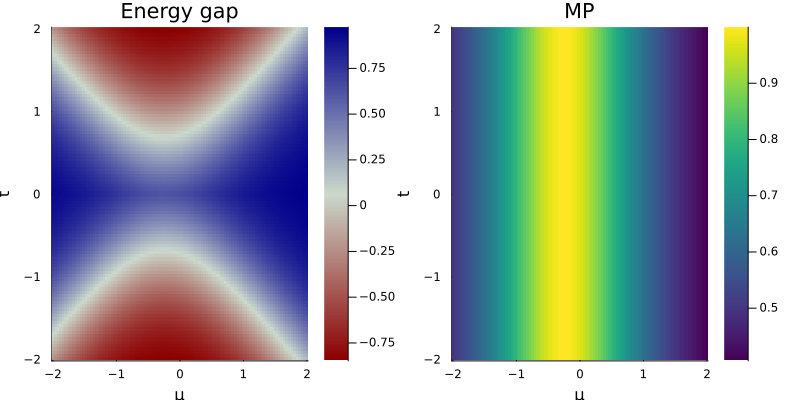

In [22]:
p1 = heatmap(μs, ts, map(x -> tanh(x.gap), data)', xlabel="μ", ylabel="t", title="Energy gap", c=:redsblues, colorrange=(-1, 1))
p2 = heatmap(μs, ts, map(x -> x.mp, data)', xlabel="μ", ylabel="t", title="MP", c=:viridis, colorrange=(0, 1))
fig = plot(p1, p2, size=400 .* (2, 1))

#### <a id='toc1_1_2_3_'></a>[Using SymPy for analytical solutions](#toc0_)

In [23]:
function fullsolve(μ::SymPy.Sym, t, Δ, V, c=c)
    H = blockdiagonal(ham(μ, t, Δ, V), c)
    Mo, Me = SymPy.Matrix.(Matrix.(blocks(H)))
    vecs_o, vals_o = Mo.diagonalize()
    vecs_e, vals_e = Me.diagonalize()
    Ee = diag(vals_e)[1]
    ve = vcat(zero(vecs_e[:, 1]), vecs_e[:, 1])
    Eo = diag(vals_o)[1]
    vo = vcat(vecs_o[:, 1], zero(vecs_o[:, 1]))
    R = 1:length(c)÷2
    return (; mp=MP(vo, ve, R, c), ld=LD(vo, ve, R, c), gap=Eo - Ee)
end

fullsolve (generic function with 4 methods)

In [24]:
SymPy.@syms μ::real t::real Δ::real V::real
foreach(p->(display(p[1]); display(p[2])), pairs(fullsolve(μ, t, Δ, V)))

:mp

|                                             2                               
|/                 __________________________\    /                 __________
||                /  2              2      2 |    |                /  2       
||    V + 2*μ + \/  V  + 4*V*μ + 4*Δ  + 4*μ  |    |    V + 2*μ + \/  V  + 4*V*
||1 - ---------------------------------------|  - |1 + -----------------------
|\                      2*Δ                  /    \                      2*Δ  

                 2|
________________\ |
       2      2 | |
μ + 4*Δ  + 4*μ  | |
----------------| |
                / |

:ld

|                                              /          ____________________
|    /             __________________________\ |             _________________
|    |            /  2              2      2 | |            /  2              
|    \V + 2*μ + \/  V  + 4*V*μ + 4*Δ  + 4*μ  /*\V + 2*μ + \/  V  + 4*V*μ + 4*Δ
|1 - -------------------------------------------------------------------------
|                                               2                             
|                                            4*Δ                              

_________\|
_________||
2      2 ||
  + 4*μ  /|
----------|
          |
          |

:gap

             __________________________
            /  2              2      2 
  V       \/  V  + 4*V*μ + 4*Δ  + 4*μ  
- - - t + -----------------------------
  2                     2              

### <a id='toc1_1_3_'></a>[Optimizing for the sweet spot](#toc0_)

In [25]:
function cost(x; Δ=1.0, V=0.5, P=1e3, c=c)
    μ, t = x
    (; gap, mp, ld) = fullsolve(μ, t, Δ, V, c)
    P * gap^2 + 1 - mp
end

cost (generic function with 1 method)

In [26]:
using BlackBoxOptim
opt = bboptimize(cost; NumDimensions=2)
sweet_spot = best_candidate(opt)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps



Optimization stopped after 10001 steps and 0.38 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 26112.26
Function evals per second = 26409.91
Improvements/step = 0.20660
Total function evaluations = 10115


Best candidate found: 

[-0.25, -0.75]

Fitness: 0.000000000



2-element Vector{Float64}:
 -0.2499999968199862
 -0.749999999979325

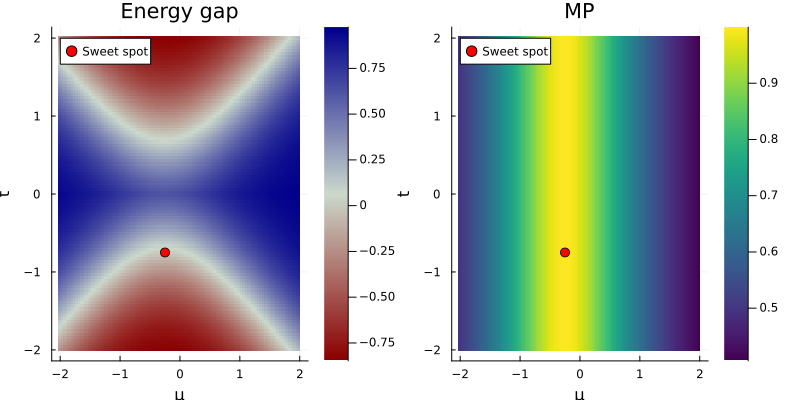

In [27]:
foreach(n -> scatter!(fig[n], [sweet_spot[1]], [sweet_spot[2]], c = :red, markersize = 5, label = "Sweet spot"), 1:2)
fig

### <a id='toc1_1_4_'></a>[Transport](#toc0_)

In [28]:
function get_leads(c, T, μ, Γ=1)
    N = length(c)
    left = QuantumDots.NormalLead(Γ * c[1]'; T, μ=μ[1])
    right = QuantumDots.NormalLead(Γ * c[N]'; T, μ=μ[2])
    return (; left, right)
end

get_leads (generic function with 2 methods)

In [29]:
function conductance(H,T,V1,V2; alg = QuantumDots.Pauli())
    leads = get_leads(c,T,(V1,V2))
    sys = alg(QuantumDots.diagonalize(QuantumDots.OpenSystem(H, leads)));
    conductance_matrix(sys)
end

conductance (generic function with 1 method)

In [30]:
function fullsolve_transport(μ, t, Δ, V, c=c; V1=0.0, V2=0.0, T=Δ / 40)
    H = ham(μ, t, Δ, V, c)
    energies, states, diag_ham = parity_eigen(H, c)
    Eₒ = first(energies[1])
    Eₑ = first(energies[2])
    ψₒ = states[1][:, 1]
    ψₑ = states[2][:, 1]
    N = length(c)
    R = 1:N÷2
    mp = MP(ψₒ, ψₑ, R, c)
    ld = LD(ψₒ, ψₑ, R, c)
    gap = Eₒ - Eₑ
    cond = conductance(H, T, V1, V2)
    return (; mp, ld, gap, cond)
end

fullsolve_transport (generic function with 2 methods)

In [31]:
using ForwardDiff

In [32]:
μs = range(-2, 2, length=100)
ts = range(-2, 2, length=100)
data_transport = [fullsolve_transport(μ, t, 1.0, 0.5) for μ in μs, t in ts];

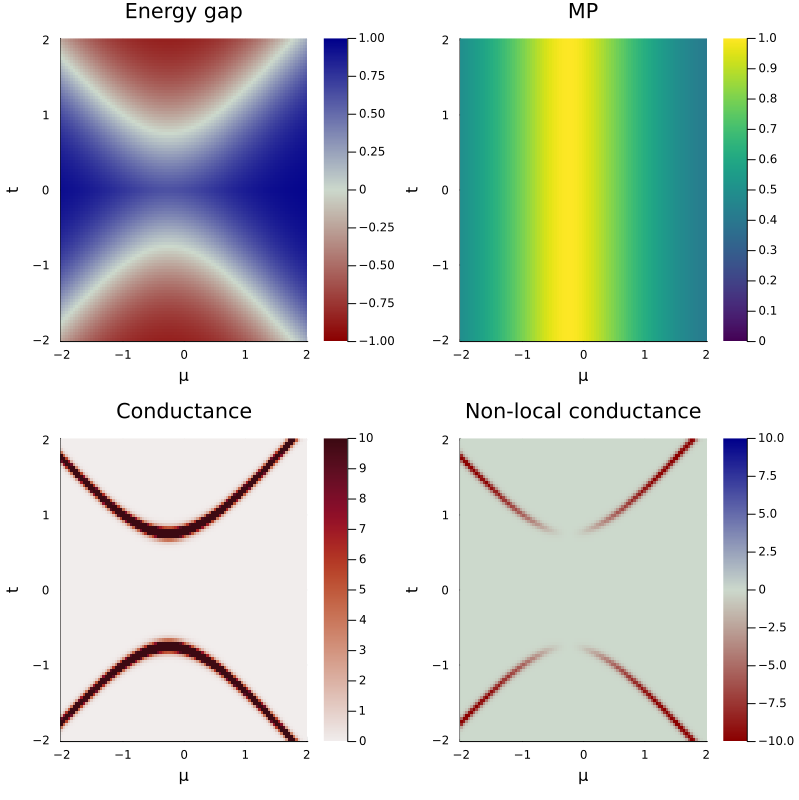

In [33]:
p1 = heatmap(μs, ts, map(x -> tanh(x.gap), data_transport)', xlabel="μ", ylabel="t", title="Energy gap", c=:redsblues, clims=(-1, 1))
p2 = heatmap(μs, ts, map(x -> x.mp, data_transport)', xlabel="μ", ylabel="t", title="MP", c=:viridis, clims=(0, 1))
p3 = heatmap(μs, ts, map(x -> x.cond[1, 1] , data_transport)', xlabel="μ", ylabel="t", title="Conductance", c=:amp, clims=(0, 10))
p4 = heatmap(μs, ts, map(x -> x.cond[1, 2], data_transport)', xlabel="μ", ylabel="t", title="Non-local conductance", c=:redsblues, clims=(-10, 10))
fig = plot(p1, p2, p3, p4, size=400 .* (2, 2))

In [34]:
μs = range(-2, 2, length=100)
bias = range(-4,4, length=100)
@time data_transport_bias = let V = .0
[fullsolve_transport(μ, 1.0- V/2, 1.0, V; V1=bias/2, V2=-bias/2) for μ in μs, bias in bias]
end;
data_transport_bias2 = let V = 1.5
[fullsolve_transport(μ, 1.0- V/2, 1.0, V; V1=bias/2, V2=-bias/2) for μ in μs, bias in bias]
end;

  1.090064 seconds (7.25 M allocations: 542.262 MiB, 11.75% gc time, 5.96% compilation time)

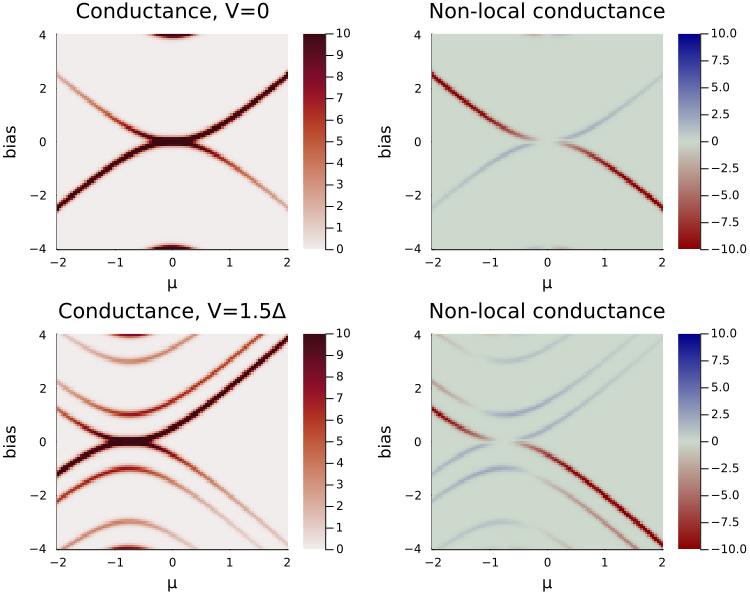

In [35]:
p1 = heatmap(μs, bias, map(x -> x.cond[1, 1], data_transport_bias)', xlabel="μ", ylabel="bias", title="Conductance, V=0", c=:amp, clims=(0, 10))
p2 = heatmap(μs, bias, map(x -> x.cond[1, 2], data_transport_bias)', xlabel="μ", ylabel="bias", title="Non-local conductance", c=:redsblues, clims=(-10, 10))
p3 = heatmap(μs, bias, map(x -> x.cond[1, 1], data_transport_bias2)', xlabel="μ", ylabel="bias", title="Conductance, V=1.5Δ", c=:amp, clims=(0, 10))
p4 = heatmap(μs, bias, map(x -> x.cond[1, 2], data_transport_bias2)', xlabel="μ", ylabel="bias", title="Non-local conductance", c=:redsblues, clims=(-10, 10))
fig = plot(p1, p2, p3, p4, size=300 .* (2.5, 2))